# Galsim optical PSF modelisation
v>=26dec25

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
mpl.rcParams["font.size"] = 16
mpl.rcParams['axes.titlesize'] = 16
plt.rcParams['image.cmap'] = 'RdBu_r'

In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../code')) # path to your source code
sys.path.insert(0, module_path)

In [3]:
from types import SimpleNamespace
import multiprocessing
import time
import regex as re
import glob
import json
import yaml
import random

import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
from torch.fft import fft2, ifft2, fftshift, ifftshift

import galsim
from model import *

In [4]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [5]:
def get_Obs_PSF(
    lam_over_diam,
    opt_defocus,
    opt_c1,
    opt_c2,
    opt_a1,
    opt_a2,
    opt_obscuration,
    atmos_fwhm,
    atmos_e,
    atmos_beta,
    spher,
    trefoil1,
    trefoil2,
    g1_err=0,
    g2_err=0,
    fov_pixels=48,
    pixel_scale=0.2,
    upsample=4,
    skip_atmos=False
):
    """Simulate a PSF from a ground-based observation. The PSF consists of an optical component and an atmospheric component.

    Args:
        lam_over_diam (float): Wavelength over diameter of the telescope.
        opt_defocus (float): Defocus in units of incident light wavelength.
        opt_c1 (float): Coma along y in units of incident light wavelength.
        opt_c2 (float): Coma along x in units of incident light wavelength.
        opt_a1 (float): Astigmatism (like e2) in units of incident light wavelength.
        opt_a2 (float): Astigmatism (like e1) in units of incident light wavelength.
        opt_obscuration (float): Linear dimension of central obscuration as fraction of pupil linear dimension, [0., 1.).
        atmos_fwhm (float): The full width at half maximum of the Kolmogorov function for atmospheric PSF.
        atmos_e (float): Ellipticity of the shear to apply to the atmospheric component.
        atmos_beta (float): Position angle (in radians) of the shear to apply to the atmospheric component, twice the phase of a complex valued shear.
        spher (float): Spherical aberration in units of incident light wavelength.
        trefoil1 (float): Trefoil along y axis in units of incident light wavelength.
        trefoil2 (float): Trefoil along x axis in units of incident light wavelength.
        g1_err (float, optional): The first component of extra shear applied to the overall PSF to simulated a erroneously estimated PSF. Defaults to `0`.
        g2_err (float, optional): The second component of extra shear applied to the overall PSF to simulated a erroneously estimated PSF. Defaults to `0`.
        fov_pixels (int, optional): Width of the simulated images in pixels. Defaults to `48`.
        pixel_scale (float, optional): Pixel scale of the simulated image determining the resolution. Defaults to `0.2`.
        upsample (int, optional): Upsampling factor for the PSF image. Defaults to `4`.

    Returns:
        `torch.Tensor`: Simulated PSF image with shape `(fov_pixels*upsample, fov_pixels*upsample)`.
    """

    # Atmospheric PSF
    atmos = galsim.Kolmogorov(fwhm=atmos_fwhm, flux=1)
    atmos = atmos.shear(e=atmos_e, beta=atmos_beta * galsim.radians)

    # Optical PSF
    optics = galsim.OpticalPSF(
        lam_over_diam,
        defocus=opt_defocus,
        coma1=opt_c1,
        coma2=opt_c2,
        astig1=opt_a1,
        astig2=opt_a2,
        spher=spher,
        trefoil1=trefoil1,
        trefoil2=trefoil2,
        obscuration=opt_obscuration,
        flux=1,
    )

    # Convolve the two components.
    if skip_atmos:
        psf=optics
    else:
        psf = galsim.Convolve([atmos, optics])

    # Shear the overall PSF to simulate a erroneously estimated PSF when necessary.
    psf = psf.shear(g1=g1_err, g2=g2_err)

    # Draw PSF images.
    psf_image = galsim.ImageF(fov_pixels * upsample, fov_pixels * upsample)
    psf.drawImage(psf_image, scale=pixel_scale / upsample, method="auto")
    psf_image = torch.from_numpy(psf_image.array)

    return psf_image

In [6]:
def gener_PSF_obs(args):
    # Atmospheric PSF
    atmos_fwhm = args.atmos_fwhm * args.rng() # Atmospheric seeing (arcsec), the FWHM of the Kolmogorov function.
    atmos_e = args.atmos_e * (1.0+ 2.0 * args.rng()) # Ellipticity of atmospheric PSF (magnitude of the shear in the “distortion” definition)
    atmos_beta = 2.0 * np.pi * args.rng()  # Shear position angle (radians), N(0,2*pi).

    # Optical PSF
    opt_defocus = args.rng_defocus()  # Defocus (wavelength), N(0.0.36).
    opt_a1 = args.rng_gaussian()  # Astigmatism (like e2) (wavelength), N(0.0.07).
    opt_a2 = args.rng_gaussian()  # Astigmatism (like e1) (wavelength), N(0.0.07).
    opt_c1 = args.rng_gaussian()  # Coma along y axis (wavelength), N(0.0.07).
    opt_c2 = args.rng_gaussian()  # Coma along x axis (wavelength), N(0.0.07).
    spher = args.rng_gaussian()  # Spherical aberration (wavelength), N(0.0.07).
    trefoil1 = args.rng_gaussian()  # Trefoil along y axis (wavelength), N(0.0.07).
    trefoil2 = args.rng_gaussian()  # Trefoil along x axis (wavelength), N(0.0.07).
    opt_obscuration = args.opt_obs_min + args.opt_obs_width * args.rng() # Linear dimension of central obscuration as fraction of pupil linear dimension, U(0.1, 0.5).
    lam_over_diam = args.lam_ov_d_min + args.lam_ov_d_width * args.rng() # Wavelength over diameter (arcsec), U(0.017, 0.024).

    psf_obs_no_atm = get_Obs_PSF(
        lam_over_diam,
        opt_defocus,
        opt_c1,
        opt_c2,
        opt_a1,
        opt_a2,
        opt_obscuration,
        atmos_fwhm,
        atmos_e,
        atmos_beta,
        spher,
        trefoil1,
        trefoil2,
        0,
        0,
        args.fov_pixels,
        args.pixel_scale,
        args.upsample,
        skip_atmos=True
    )

    psf_obs_atm = get_Obs_PSF(
        lam_over_diam,
        opt_defocus,
        opt_c1,
        opt_c2,
        opt_a1,
        opt_a2,
        opt_obscuration,
        atmos_fwhm,
        atmos_e,
        atmos_beta,
        spher,
        trefoil1,
        trefoil2,
        0,
        0,
        args.fov_pixels,
        args.pixel_scale,
        args.upsample,
        skip_atmos=False
    )
 
    
    return psf_obs_no_atm, psf_obs_atm,\
            {"atm":{"fwhm":atmos_fwhm,"e":atmos_e,"beta":atmos_beta},
             "opt":{"lod":lam_over_diam,
        "defocus":opt_defocus,
        "coma1":opt_c1,
        "coma2":opt_c2,
        "astig1":opt_a1,
        "astig2":opt_a2,
        "obs":opt_obscuration,
        "spher":spher,
        "tref1":trefoil1,
        "tref2":trefoil2}}

In [7]:
def crop_center(arr, npix=64):
    return arr[arr.shape[0]//2-npix//2:arr.shape[0]//2+npix//2,
        arr.shape[1]//2-npix//2:arr.shape[1]//2+npix//2]

In [8]:
def format_float_values(obj):
    if isinstance(obj, float):
        return round(obj, 3)
    elif isinstance(obj, dict):
        return {k: format_float_values(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [format_float_values(item) for item in obj]
    else:
        return obj

In [9]:
config_file = "./config_DeconvNoisy_COSMOS_4nb.yaml"


with open(config_file, "r") as config:
    settings_dict = yaml.safe_load(config)
args = SimpleNamespace(**settings_dict)

In [15]:
args.seed=103112025 # to reproduce paper image

In [16]:
def reset_rnd_func(args):
    set_seed(args.seed)
    # update settings for galaxy simulator (used in GalaxyDataset)    
    args.rng_base = galsim.BaseDeviate(seed=args.seed)
    args.rng = galsim.UniformDeviate(seed=args.seed)  # U(0,1).
    args.rng_defocus = galsim.GaussianDeviate(
        args.rng_base, mean=0.0, sigma=args.sigma_defocus)
    args.rng_gaussian = galsim.GaussianDeviate(
        args.rng_base, mean=0.0, sigma=args.sigma_opt_psf
    ) 
    args.rng_gal_shear = galsim.DistDeviate(
        seed=args.rng, function=lambda x: x, x_min=args.min_shear, x_max=args.max_shear
    )

In [17]:
reset_rnd_func(args)

all_psf_optics = []
all_psf_atm = []
all_infos = []
for i in range(19):
    psf_obs_no_atm,psf_obs_atm,info = gener_PSF_obs(args)
    all_psf_optics.append(psf_obs_no_atm)
    all_psf_atm.append(psf_obs_atm)
    all_infos.append(info)


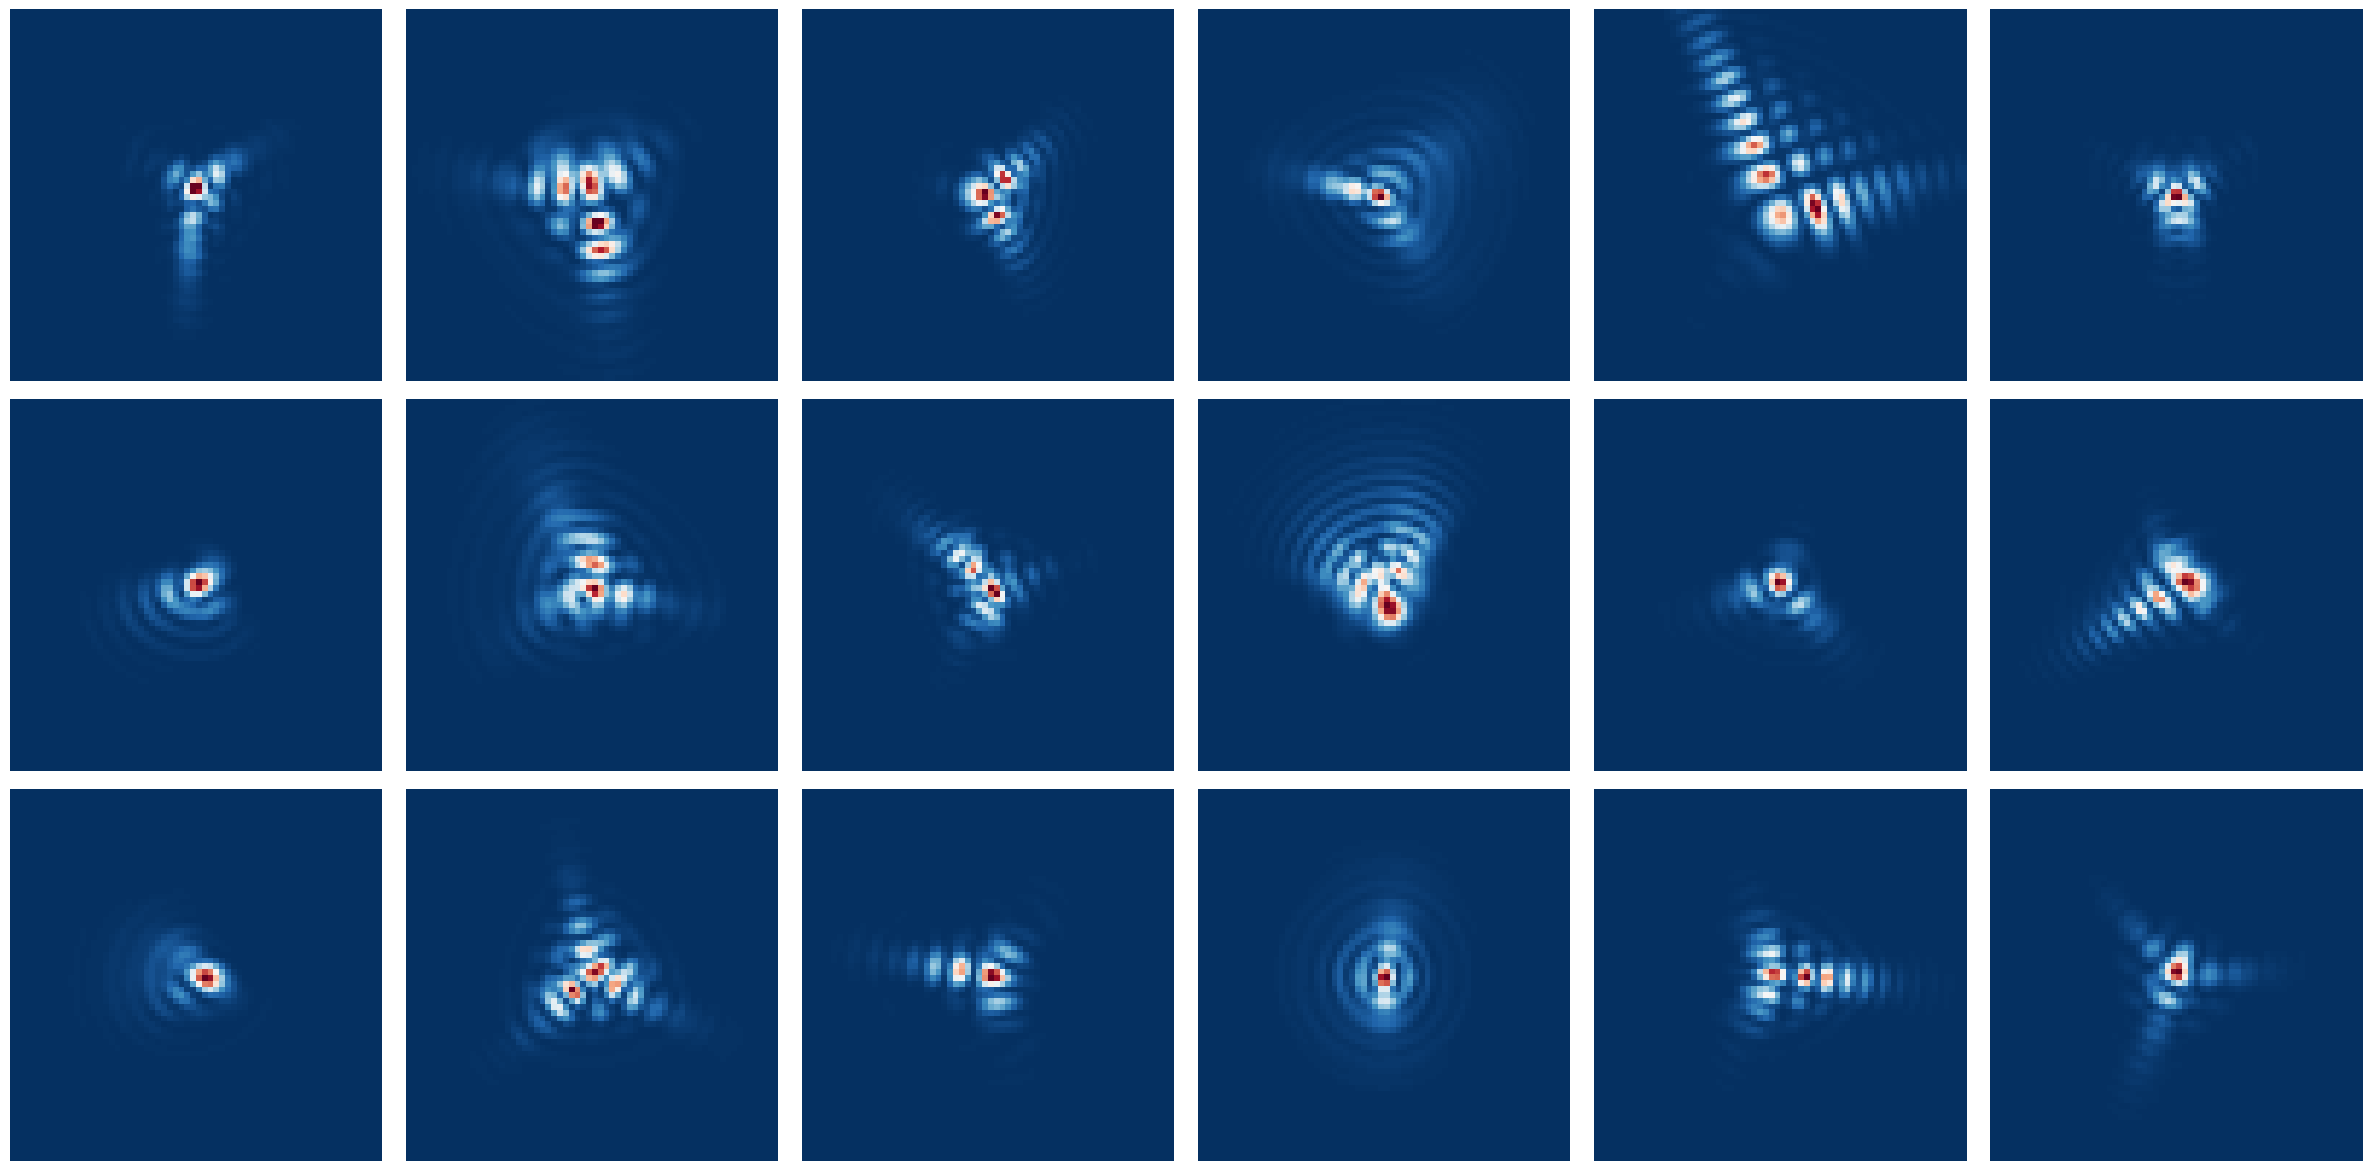

In [18]:
fig, axs = plt.subplots(3, 6, figsize=(4*6, 4*3))
i=1
for l in range(3):
    for c in range(6):
        psf_obs_no_atm = all_psf_optics[i]
        psf_obs_atm = all_psf_atm[i]
        i=i+1
        
        axs[l,c].imshow(crop_center(psf_obs_no_atm.cpu().squeeze()))
        axs[l,c].axis("off")

plt.tight_layout()
#plt.savefig("psf_optics_exemple_18.pdf");

(2,)


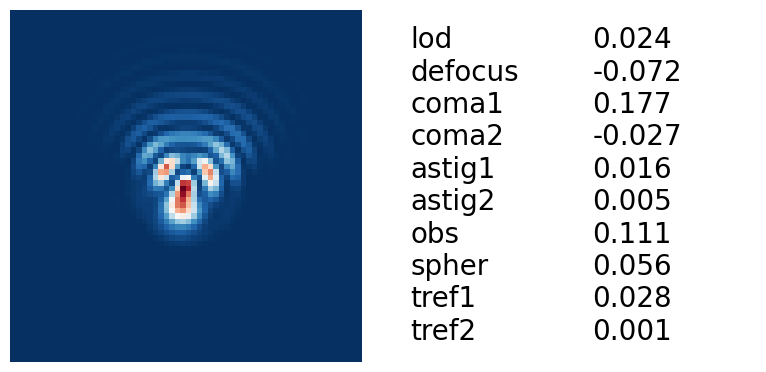

In [19]:
# Création d'une figure
# 3X10 psf
#reset_rnd_func(args)
fig, axs = plt.subplots(1, 2, figsize=(4*2, 4))
print(axs.shape)
psf_obs_no_atm = all_psf_optics[0]
info = all_infos[0]
data = format_float_values(info["opt"])
table_data = [[k, v] for k, v in data.items()]
table=axs[1].table(
            cellText=table_data,
            loc="center",
            cellLoc="left",
            edges="open",
        )
table.set_fontsize(20)
table.scale(1, 1.7)
axs[0].imshow(crop_center(psf_obs_no_atm.cpu().squeeze()))
axs[0].axis("off")
axs[1].axis("off")
plt.tight_layout();
#plt.savefig("psf_optics_exemple_single.pdf");